# 2D Latent Diffusion Model

In [1]:
# TODO: Add buttom with "Open with Colab"

## Set up environment using Colab


In [2]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Set up imports

In [3]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import LatentDiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()

/media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-02-12 12:57:59,630 - A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
MONAI version: 1.2.dev2304
Numpy version: 1.23.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9a57be5aab9f2c2a134768c0c146399150e247a0
MONAI __file__: /media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.

In [4]:
# for reproducibility purposes set a seed
set_determinism(42)

## Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpy2pm22t5


## Download the training set

In [6]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        # TODO: Change transformations
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)

MedNIST.tar.gz: 59.0MB [00:03, 16.7MB/s]                                                                                                                                                                                       

2023-02-12 12:58:03,382 - INFO - Downloaded: /tmp/tmpy2pm22t5/MedNIST.tar.gz


2023-02-12 12:58:03,455 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-02-12 12:58:03,456 - INFO - Writing into directory: /tmp/tmpy2pm22t5.


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:13<00:00, 3371.48it/s]


## Visualise examples from the training set

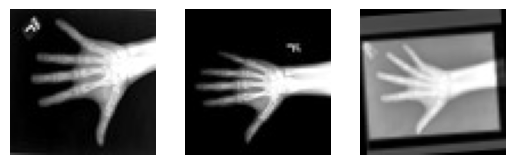

In [7]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

## Download the validation set

In [8]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4)

2023-02-12 12:58:22,141 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-02-12 12:58:22,142 - INFO - File exists: /tmp/tmpy2pm22t5/MedNIST.tar.gz, skipped downloading.
2023-02-12 12:58:22,142 - INFO - Non-empty folder exists in /tmp/tmpy2pm22t5/MedNIST, skipped extracting.


Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5895/5895 [00:01<00:00, 3357.20it/s]


## Define the network

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [10]:
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=64,
    latent_channels=3,
    ch_mult=(1, 2, 2),
    num_res_blocks=1,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
autoencoderkl = autoencoderkl.to(device)

In [11]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=1,
    num_channels=(128, 256, 256),
    num_head_channels=256,
)

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    beta_start=0.0015,
    beta_end=0.0195,
)

discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    num_channels=32,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)

PatchDiscriminator(
  (initial_conv): Convolution(
    (conv): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (adn): ADN(
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (0): Convolution(
    (conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): Convolution(
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): Convolution(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (adn): ADN(
      (N): Batch

In [12]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.001

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.


In [13]:
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

## Train AutoencoderKL

It takes about ~55 min to train the model.

In [14]:
kl_weight = 1e-6
n_epochs = 100
val_interval = 6
autoencoder_warm_up_n_epochs = 10

epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(enabled=True):
                optimizer_d.zero_grad(set_to_none=True)

                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoderkl(images)
                    # Get the first sammple from the first validation batch for visualisation
                    # purposes
                    if val_step == 1:
                        intermediary_images.append(reconstruction[:n_example_images, 0])

                    recons_loss = F.l1_loss(images.float(), reconstruction.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()


Epoch 5: 100%|█████████████████| 125/125 [00:10<00:00, 11.41it/s, recons_loss=0.0307, gen_loss=0, disc_loss=0]


epoch 6 val loss: 0.0319


Epoch 11: 100%|████████| 125/125 [00:13<00:00,  9.53it/s, recons_loss=0.0243, gen_loss=0.396, disc_loss=0.323]


epoch 12 val loss: 0.0265


Epoch 17: 100%|███████████| 125/125 [00:12<00:00,  9.69it/s, recons_loss=0.023, gen_loss=0.3, disc_loss=0.241]


epoch 18 val loss: 0.0239


Epoch 23: 100%|████████| 125/125 [00:12<00:00,  9.83it/s, recons_loss=0.0216, gen_loss=0.293, disc_loss=0.239]


epoch 24 val loss: 0.0236


Epoch 29: 100%|████████| 125/125 [00:12<00:00,  9.84it/s, recons_loss=0.0203, gen_loss=0.299, disc_loss=0.238]


epoch 30 val loss: 0.0210


Epoch 35: 100%|████████| 125/125 [00:12<00:00,  9.77it/s, recons_loss=0.0199, gen_loss=0.308, disc_loss=0.238]


epoch 36 val loss: 0.0204


Epoch 41: 100%|████████| 125/125 [00:12<00:00,  9.82it/s, recons_loss=0.0185, gen_loss=0.306, disc_loss=0.235]


epoch 42 val loss: 0.0200


Epoch 47: 100%|█████████| 125/125 [00:12<00:00,  9.86it/s, recons_loss=0.0185, gen_loss=0.333, disc_loss=0.23]


epoch 48 val loss: 0.0196


Epoch 53: 100%|████████| 125/125 [00:12<00:00,  9.72it/s, recons_loss=0.0175, gen_loss=0.322, disc_loss=0.232]


epoch 54 val loss: 0.0186


Epoch 59: 100%|████████| 125/125 [00:12<00:00,  9.81it/s, recons_loss=0.0175, gen_loss=0.341, disc_loss=0.227]


epoch 60 val loss: 0.0182


Epoch 65: 100%|████████| 125/125 [00:12<00:00,  9.85it/s, recons_loss=0.0174, gen_loss=0.366, disc_loss=0.214]


epoch 66 val loss: 0.0184


Epoch 71: 100%|█████████| 125/125 [00:12<00:00,  9.79it/s, recons_loss=0.0178, gen_loss=0.41, disc_loss=0.209]


epoch 72 val loss: 0.0195


Epoch 77: 100%|███████████| 125/125 [00:12<00:00,  9.76it/s, recons_loss=0.018, gen_loss=0.415, disc_loss=0.2]


epoch 78 val loss: 0.0193


Epoch 83: 100%|█████████| 125/125 [00:12<00:00,  9.85it/s, recons_loss=0.0181, gen_loss=0.46, disc_loss=0.191]


epoch 84 val loss: 0.0192


Epoch 89: 100%|████████| 125/125 [00:12<00:00,  9.78it/s, recons_loss=0.0177, gen_loss=0.515, disc_loss=0.155]


epoch 90 val loss: 0.0204


Epoch 95: 100%|████████| 125/125 [00:12<00:00,  9.85it/s, recons_loss=0.0185, gen_loss=0.518, disc_loss=0.164]


epoch 96 val loss: 0.0198


Epoch 99: 100%|████████| 125/125 [00:12<00:00,  9.83it/s, recons_loss=0.0188, gen_loss=0.553, disc_loss=0.146]


### Visualise the results from the autoencoderKL

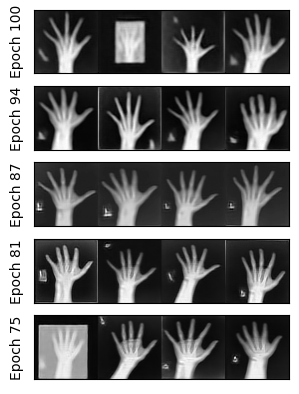

In [15]:
# Plot last 5 evaluations
val_samples = np.linspace(n_epochs, val_interval, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=5, ncols=1, sharey=True)
for image_n in range(5):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * n_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

## Train Diffusion Model

### Scaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) can affect the results obtained with the LDM, if the standard deviation of the latent space distribution drifts too much from that of a Gaussian. For this reason, it is best practice to use a scaling factor to adapt this standard deviation.

_Note: In case where the latent space is close to a Gaussian distribution, the scaling factor will be close to one, and the results will not differ from those obtained when it is not used._


In [16]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to tensor(0.9627, device='cuda:0')


We define the inferer using the scale factor:

In [17]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

It takes about ~80 min to train the model.

Epoch 39: 100%|████████| 125/125 [00:10<00:00, 11.98it/s, loss=0.0905]


Epoch 39 val loss: 0.0897


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.88it/s]


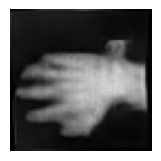

Epoch 79: 100%|████████| 125/125 [00:09<00:00, 13.21it/s, loss=0.0873]


Epoch 79 val loss: 0.0833


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.81it/s]


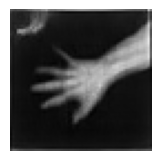

Epoch 119: 100%|███████| 125/125 [00:09<00:00, 13.16it/s, loss=0.0834]


Epoch 119 val loss: 0.0820


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.12it/s]


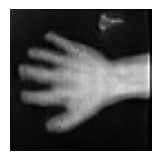

Epoch 159: 100%|███████| 125/125 [00:09<00:00, 12.88it/s, loss=0.0826]


Epoch 159 val loss: 0.0799


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.43it/s]


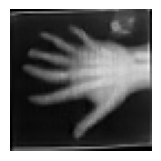

Epoch 199: 100%|███████| 125/125 [00:09<00:00, 12.89it/s, loss=0.0787]


Epoch 199 val loss: 0.0763


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.06it/s]


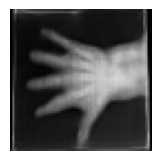

In [18]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

unet = unet.to(device)
n_epochs = 200
val_interval = 40
epoch_loss_list = []
val_epoch_loss_list = []
scaler = GradScaler()

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            z_mu, z_sigma = autoencoderkl.encode(images)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps, autoencoder_model=autoencoderkl
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix(
            {
                "loss": epoch_loss / (step + 1),
            }
        )
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    z_mu, z_sigma = autoencoderkl.encode(images)
                    z = autoencoderkl.sampling(z_mu, z_sigma)

                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=unet,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoderkl,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_epoch_loss_list.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training
        z = torch.randn((1, 3, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=unet, scheduler=scheduler, autoencoder_model=autoencoderkl
            )

        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(decoded[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
progress_bar.close()


### Plotting sampling example

In [19]:
unet.eval()
image = torch.randn((1, 1, 64, 64))
image = image.to(device)
scheduler.set_timesteps(num_inference_steps=1000)

with torch.no_grad():

    z_mu, z_sigma = autoencoderkl.encode(image)
    z = autoencoderkl.sampling(z_mu, z_sigma)

    noise = torch.randn_like(z).to(device)
    image, intermediates = inferer.sample(
        input_noise=z,
        diffusion_model=unet,
        scheduler=scheduler,
        save_intermediates=True,
        intermediate_steps=100,
        autoencoder_model=autoencoderkl,
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.08it/s]


(-0.5, 639.5, 63.5, -0.5)

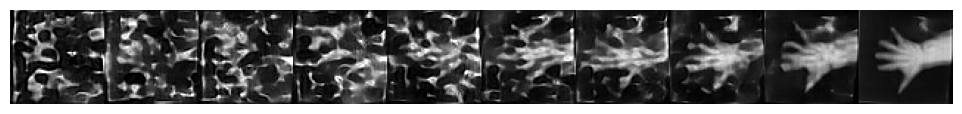

In [20]:
# Invert the autoencoderKL model
decoded_images = []
for image in intermediates:
    with torch.no_grad():
        decoded_images.append(image)
plt.figure(figsize=(10, 12))
chain = torch.cat(decoded_images, dim=-1)
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")

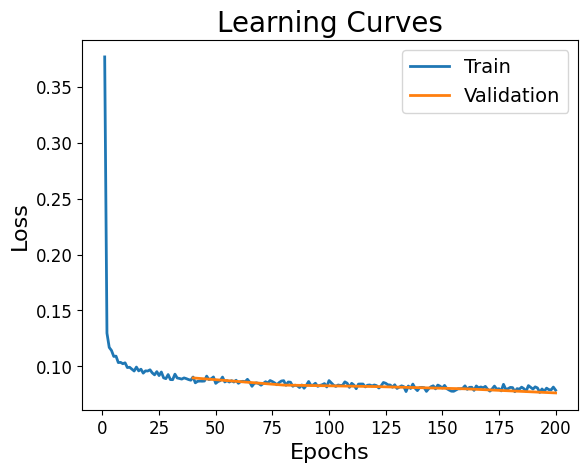

In [21]:
# ## Plot learning curves
plt.figure()
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_epoch_loss_list,
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})

In [22]:
### Clean-up data directory

In [23]:
if directory is None:
    shutil.rmtree(root_dir)